In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("/Users/insiyar/Documents/Development/bird-song-classifier/CNN-Workflow/spectrogram_species_data.csv")

In [4]:
data.describe

<bound method NDFrame.describe of           id     species               name  png_filename
0     557838    bewickii      Bewick's Wren  557838-0.png
1     557838    bewickii      Bewick's Wren  557838-1.png
2     557838    bewickii      Bewick's Wren  557838-4.png
3     557838    bewickii      Bewick's Wren  557838-5.png
4     557838    bewickii      Bewick's Wren  557838-6.png
...      ...         ...                ...           ...
5417   11713  cardinalis  Northern Cardinal   11713-8.png
5418   11713  cardinalis  Northern Cardinal  11713-10.png
5419   11713  cardinalis  Northern Cardinal  11713-14.png
5420   11713  cardinalis  Northern Cardinal  11713-15.png
5421   11713  cardinalis  Northern Cardinal  11713-16.png

[5422 rows x 4 columns]>

In [5]:
labels = data['name'].unique() 
print(labels)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [6]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
from tqdm import tqdm

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255. # Normalize pixel values to [0, 1]
    return img_array

def process_images_in_batches(data, batch_size=500):
    images = []
    labels = []
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing images"):
        img_path = os.path.join('/Users/insiyar/Documents/Development/bird-song-classifier/output_spectrogram_folder', row['png_filename'])
        img_array = load_and_preprocess_image(img_path)
        images.append(img_array)
        labels.append(row['species'])
        
        if len(images) % batch_size == 0:
            images = np.concatenate(images, axis=0) 
            labels = np.array(labels)
            yield images, labels
            images = []
            labels = []
    
    if images:
        images = np.concatenate(images, axis=0) 
        labels = np.array(labels)
        yield images, labels

# Process the training and testing sets in batches
train_images, train_labels = [], []
test_images, test_labels = [], []

for batch_images, batch_labels in process_images_in_batches(train_data):
    train_images.append(batch_images)
    train_labels.append(batch_labels)

for batch_images, batch_labels in process_images_in_batches(test_data):
    test_images.append(batch_images)
    test_labels.append(batch_labels)

train_images = np.concatenate(train_images, axis=0) # Ensure train_images is a 4D array
train_labels = np.concatenate(train_labels, axis=0) # Ensure train_labels is a 1D array
test_images = np.concatenate(test_images, axis=0) # Ensure test_images is a 4D array
test_labels = np.concatenate(test_labels, axis=0) # Ensure test_labels is a 1D array

Processing images: 100%|██████████| 1085/1085 [00:15<00:00, 71.43it/s]


In [37]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(train_labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/insiyar/anaconda3/envs/audio/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [39]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform train_labels
train_labels = label_encoder.fit_transform(train_labels)

# Transform test_labels
test_labels = label_encoder.transform(test_labels)

# Print the unique encoded labels
print("Encoded class labels:", np.unique(train_labels))

# Print the mapping of original class labels to encoded labels
print("Class label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Encoded class labels: [0 1 2 3 4]
Class label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [40]:
history = model.fit(train_generator, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10


/Users/insiyar/anaconda3/envs/audio/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.2168 - loss: 1.6926 - val_accuracy: 0.2461 - val_loss: 1.5848
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.2728 - loss: 1.5747 - val_accuracy: 0.2608 - val_loss: 1.5414
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.2833 - loss: 1.5385 - val_accuracy: 0.3687 - val_loss: 1.4874
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.3368 - loss: 1.4982 - val_accuracy: 0.3982 - val_loss: 1.3534
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3871 - loss: 1.3834 - val_accuracy: 0.4516 - val_loss: 1.2736
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.4430 - loss: 1.2916 - val_accuracy: 0.5419 - val_loss: 1.1160
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.4640 - loss: 1.2226 - val_accuracy: 0.5613 - val_loss: 1.0336
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.4897 - loss: 1.1881 - val_accuracy: 0.514

In [49]:
history_no_aug = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.8461 - loss: 0.4269 - val_accuracy: 0.8406 - val_loss: 0.4026
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.8863 - loss: 0.3064 - val_accuracy: 0.8562 - val_loss: 0.3553
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9256 - loss: 0.2216 - val_accuracy: 0.8664 - val_loss: 0.3738
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9458 - loss: 0.1573 - val_accuracy: 0.8470 - val_loss: 0.4281
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 406s 3s/step - accuracy: 0.9585 - loss: 0.1245 - val_accuracy: 0.8765 - val_loss: 0.3733
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9707 - loss: 0.0908 - val_accuracy: 0.8876 - val_loss: 0.3908
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9772 - loss: 0.0701 - val_accuracy: 0.8848 - val_loss: 0.3882
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9800 - loss: 0.0568 - val_accu

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.8979 - loss: 0.3210
Test accuracy: 0.8921658992767334


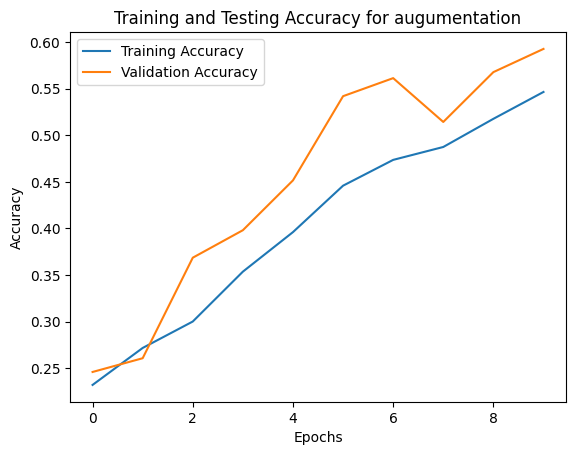

In [51]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Plot the training and testing accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Testing Accuracy for augumentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 328ms/step - accuracy: 0.8979 - loss: 0.3210
Test accuracy: 0.8921658992767334


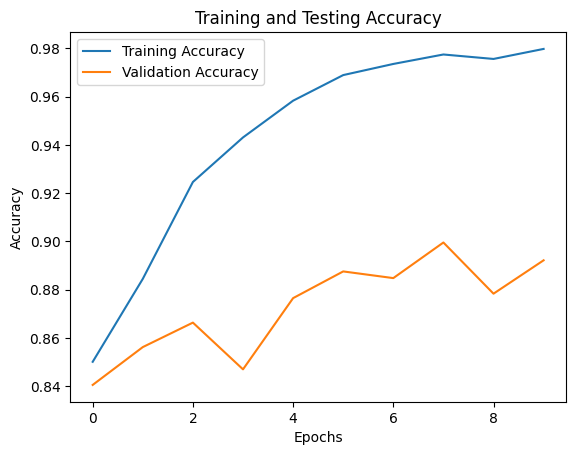

In [50]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Plot the training and testing accuracy
import matplotlib.pyplot as plt

plt.plot(history_no_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_no_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
